In [3]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [4]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [5]:
mnist_train_y = hd5_open('../../DHC/scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../../DHC/scratch_AKS/mnist_test_y.h5','main/data')

In [6]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_21/mnist_DHC_train_ang_1_1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_21/mnist_DHC_test_ang_1_1.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_train = DHC_iso_vec(mnist_DHC_out_sizetrain,5,8)

In [7]:
M = 100
angle_array = [i for i in np.linspace(2*np.pi/M,2*np.pi,M)]
angle_test = np.tile(angle_array,10000)

In [8]:
mnist_DHC_out_sizetest.shape, angle_test.shape

((1000000, 1724), (1000000,))

In [13]:
angle_test[100:200]

array([0.06283185, 0.12566371, 0.18849556, 0.25132741, 0.31415927,
       0.37699112, 0.43982297, 0.50265482, 0.56548668, 0.62831853,
       0.69115038, 0.75398224, 0.81681409, 0.87964594, 0.9424778 ,
       1.00530965, 1.0681415 , 1.13097336, 1.19380521, 1.25663706,
       1.31946891, 1.38230077, 1.44513262, 1.50796447, 1.57079633,
       1.63362818, 1.69646003, 1.75929189, 1.82212374, 1.88495559,
       1.94778745, 2.0106193 , 2.07345115, 2.136283  , 2.19911486,
       2.26194671, 2.32477856, 2.38761042, 2.45044227, 2.51327412,
       2.57610598, 2.63893783, 2.70176968, 2.76460154, 2.82743339,
       2.89026524, 2.95309709, 3.01592895, 3.0787608 , 3.14159265,
       3.20442451, 3.26725636, 3.33008821, 3.39292007, 3.45575192,
       3.51858377, 3.58141563, 3.64424748, 3.70707933, 3.76991118,
       3.83274304, 3.89557489, 3.95840674, 4.0212386 , 4.08407045,
       4.1469023 , 4.20973416, 4.27256601, 4.33539786, 4.39822972,
       4.46106157, 4.52389342, 4.58672527, 4.64955713, 4.71238

In [11]:
mnist_test_y[1]

2

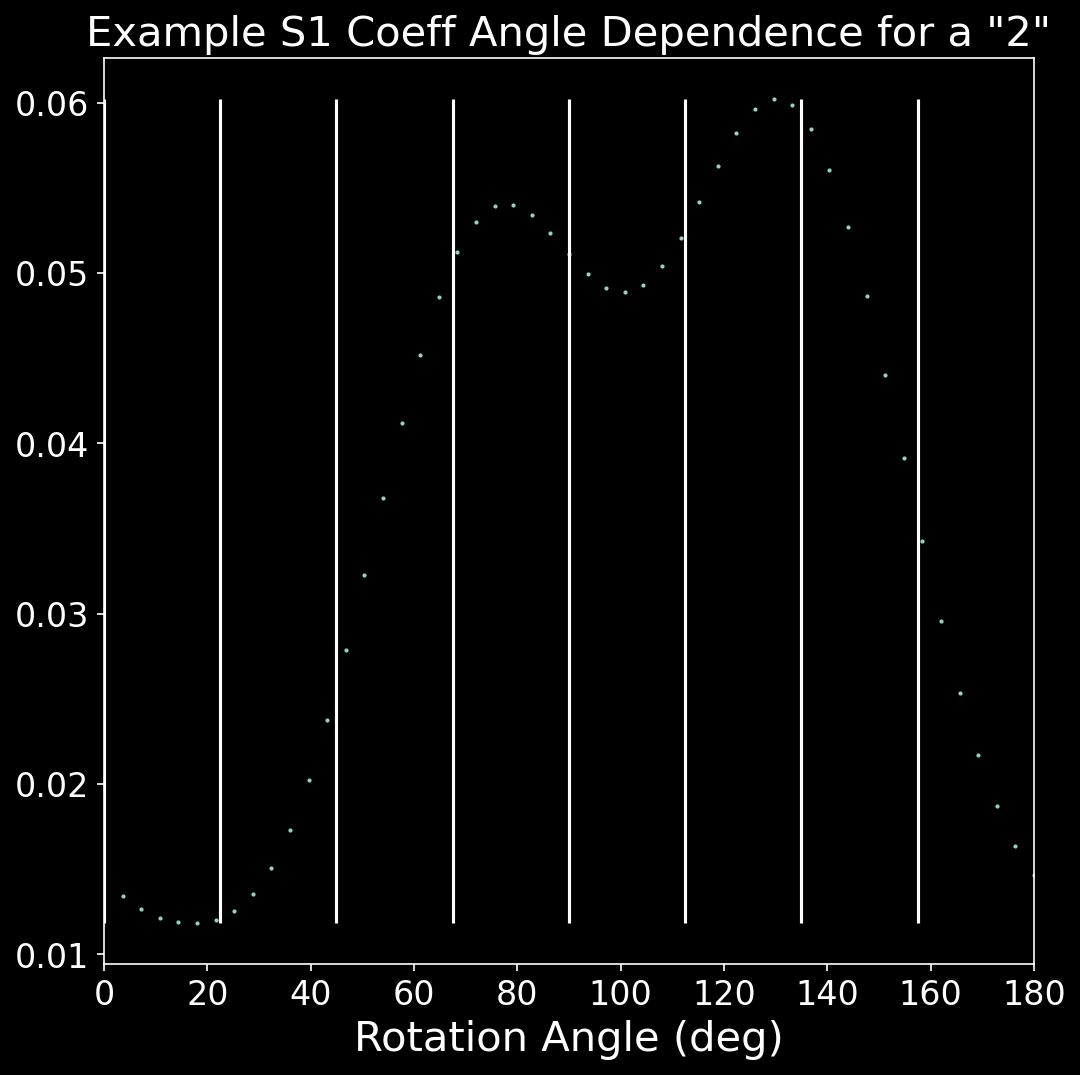

In [43]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = mnist_DHC_out_sizetest[100:200,2+2*6+0]

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)

min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

The fact that the peak is rotated relative to the basis tells me something about the absolute instead of relative angle I think. Maybe some hope of extracting this parameter from such a hyper sweep?

In [44]:
from scipy import interpolate

In [45]:
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

In [50]:
mnist_DHC_out_sizetest[100:200,:].shape,(angle_test[100:200]*180/np.pi).shape

((100, 1724), (100,))

In [51]:
f = interpolate.interp1d(angle_test[100:200]*180/np.pi, mnist_DHC_out_sizetest[100:200,:],axis=0)

In [56]:
f([5,10]).shape

(2, 1724)

Dumbest Test, seems I do not have the angles exactly spaced by pi/8... not a big deal because it is clear we need more L in order to do the interpolation well.

In [72]:
for i in range(100,200,6):
    print(i)

100
106
112
118
124
130
136
142
148
154
160
166
172
178
184
190
196


In [73]:
angle_test[range(100,200,6)]

array([0.06283185, 0.43982297, 0.81681409, 1.19380521, 1.57079633,
       1.94778745, 2.32477856, 2.70176968, 3.0787608 , 3.45575192,
       3.83274304, 4.20973416, 4.58672527, 4.96371639, 5.34070751,
       5.71769863, 6.09468975])

In [74]:
f = interpolate.interp1d(angle_test[range(100,200,6)]*180/np.pi, mnist_DHC_out_sizetest[range(100,200,6),:],axis=0,fill_value='extrapolate')

In [75]:
ext_y = f(angle_test[100:200]*180/np.pi)

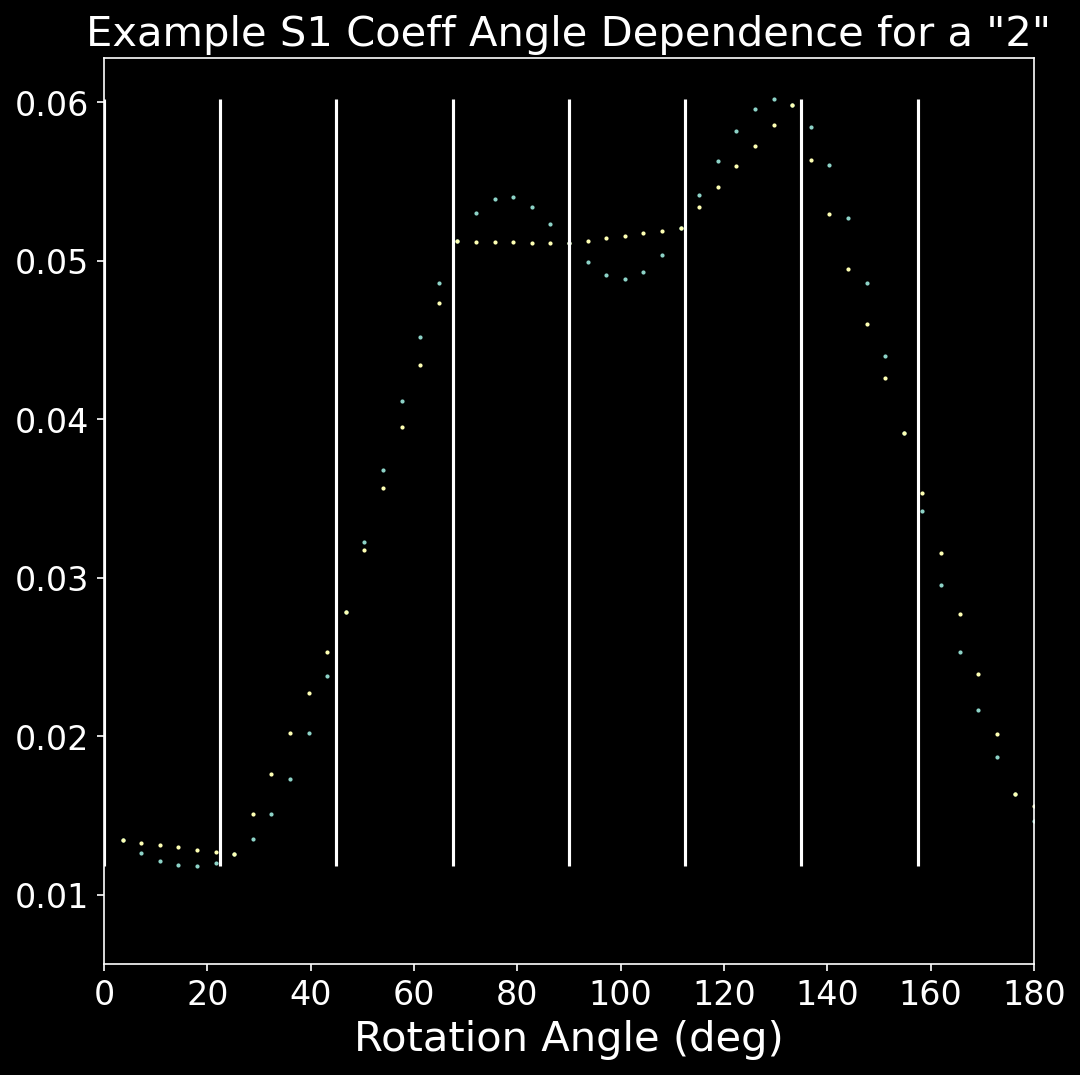

In [76]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = mnist_DHC_out_sizetest[100:200,2+2*6+0]

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)

data1 = ext_y[:,2+2*6+0]

plt.scatter(angle_test[100:200]*180/np.pi,data1,s=1)

min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [84]:
temp = np.abs(data-data1)/np.abs(data)

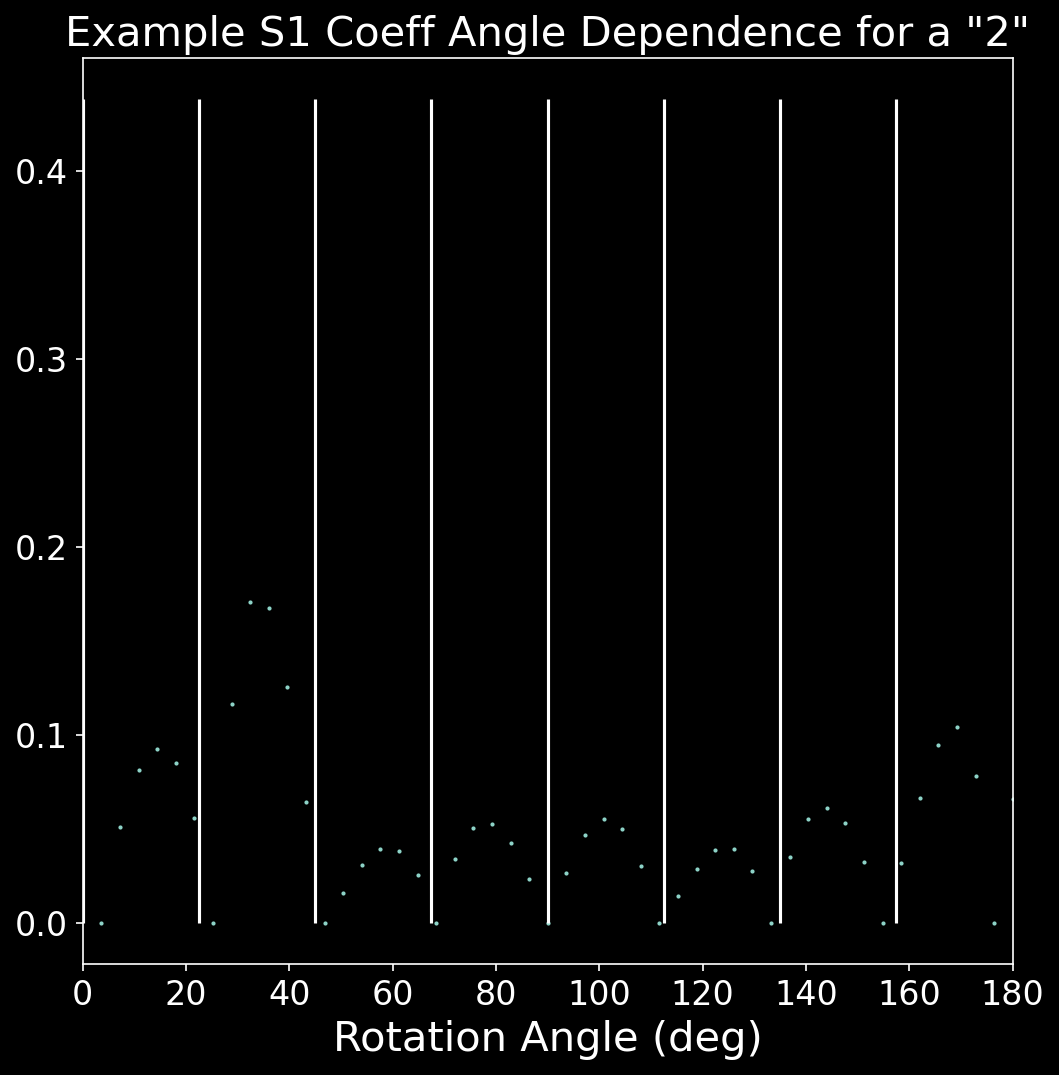

In [86]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = temp

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)


min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [91]:
temp = np.abs(mnist_DHC_out_sizetest[100:200,:]-ext_y)/np.abs(mnist_DHC_out_sizetest[100:200,:])

In [94]:
np.mean(temp,axis=1).shape

(100,)

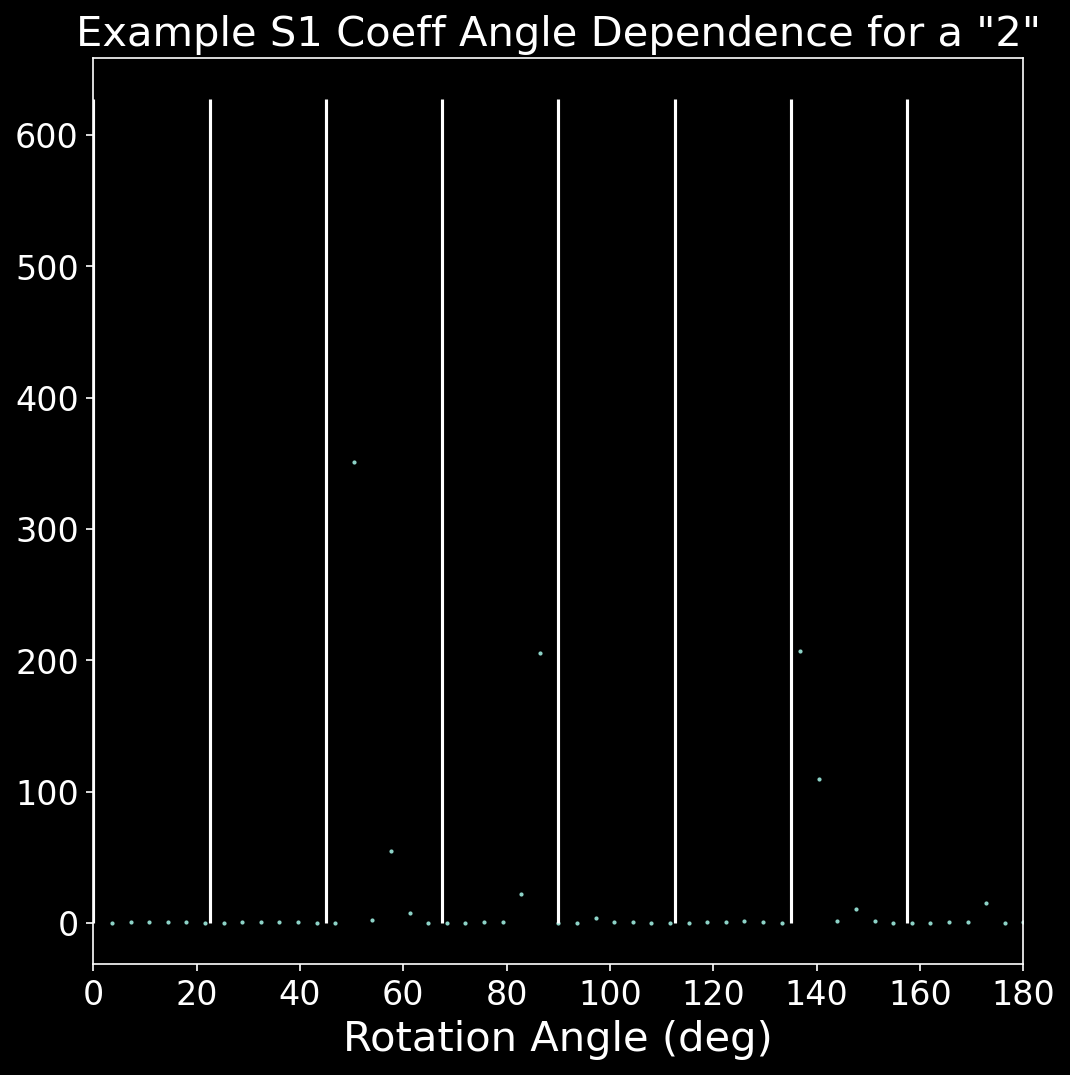

In [95]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = np.mean(temp,axis=1)

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)


min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

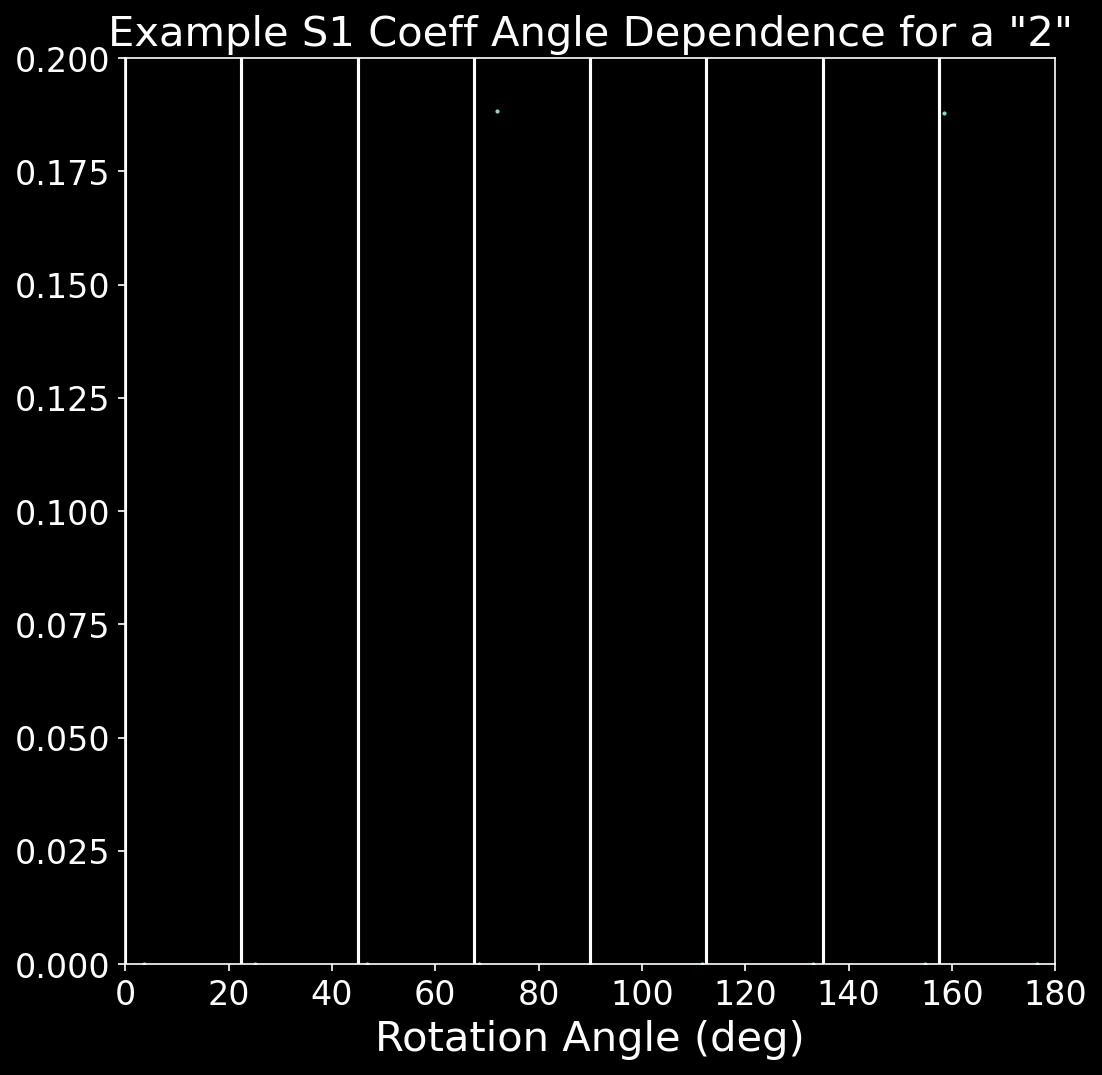

In [98]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = np.mean(temp,axis=1)

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)


min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])
plt.ylim([0,0.2])

plt.show()

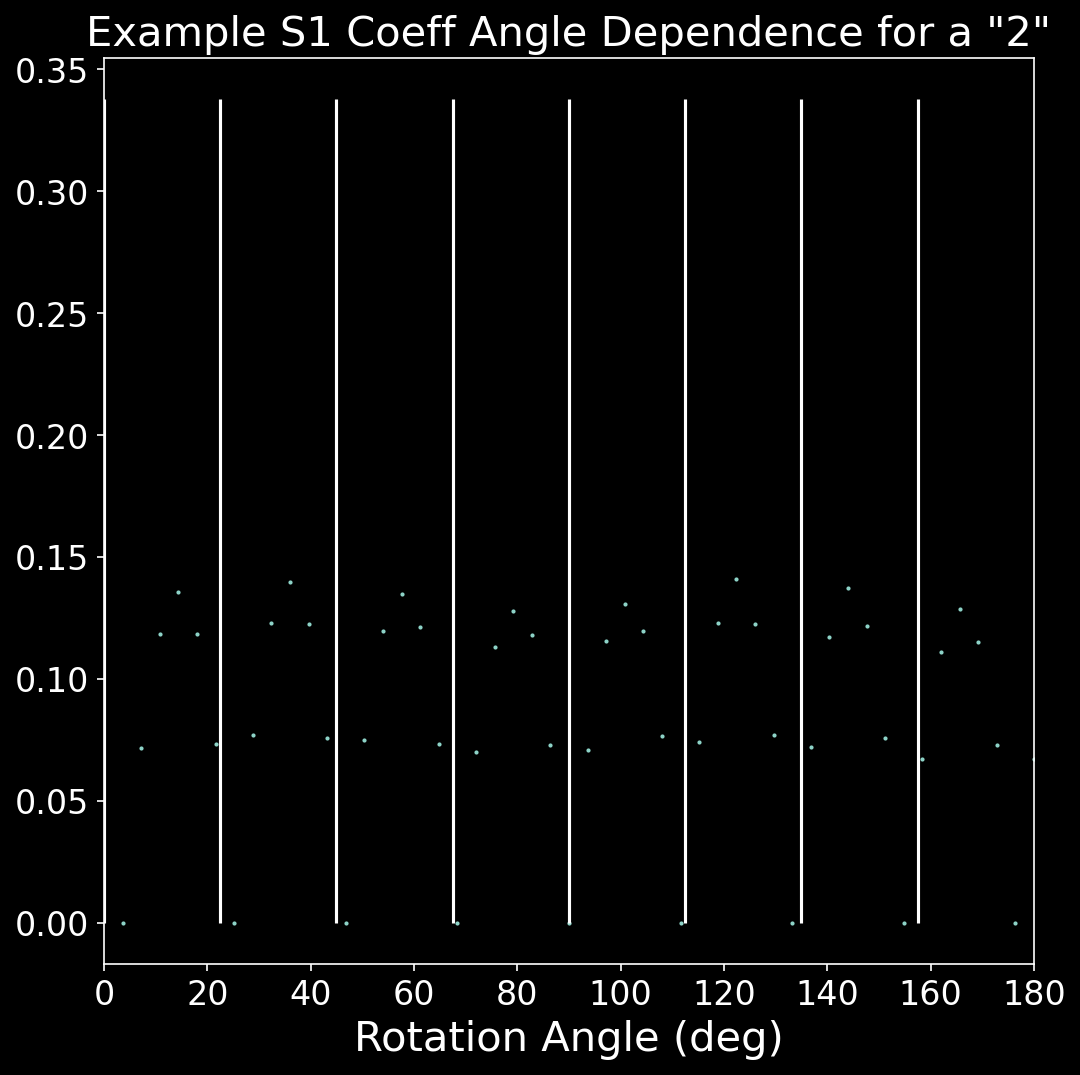

In [101]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = np.median(temp,axis=1)

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)


min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [115]:
temp = np.abs(mnist_DHC_out_sizetest[100:200,:]-ext_y)/np.max([np.abs(mnist_DHC_out_sizetest[100:200,:]),np.abs(ext_y)],axis=0)

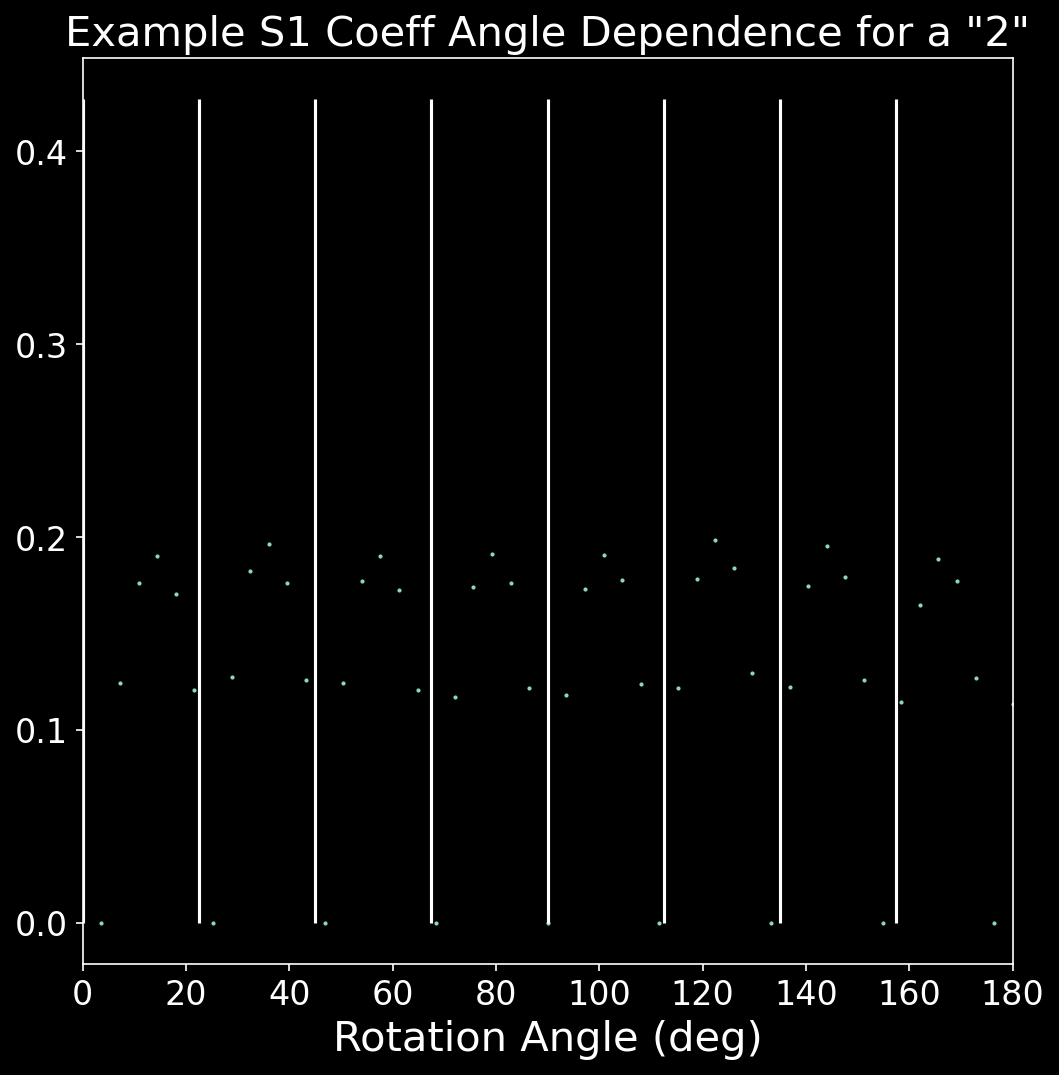

In [116]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
data = np.mean(temp,axis=1)

plt.scatter(angle_test[100:200]*180/np.pi,data,s=1)


min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [123]:
rad = np.array([2**r for r in range(2,8)])
rad

array([  4,   8,  16,  32,  64, 128])

In [128]:
32/(rad*1*np.pi)

array([2.54647909, 1.27323954, 0.63661977, 0.31830989, 0.15915494,
       0.07957747])